<a href="https://colab.research.google.com/github/pouyarb/Algorithm/blob/main/optimization_problems/RiskParity_rev02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install yahoofinancials
!pip install pyfeng

In [2]:
import pandas as pd
import numpy as np

from pyfeng import RiskParity

import yfinance as yf
from yahoofinancials import YahooFinancials
from itertools import combinations
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns

# load data

In [3]:
# list from https://www.cnbc.com/dow-30/
Dow_list = [  'AXP', 'AMGN', 'AAPL','BA','CAT','CSCO', 'CVX',
              'GS', 'HD', 'HON', 'IBM','INTC','JNJ', 'KO', 'JPM',
              'MCD','MMM', 'MRK','MSFT','NKE','PG','TRV','UNH', 'CRM',
              'VZ','V', 'WBA', 'WMT','DIS', 'DOW']
print(len(Dow_list))

30


In [4]:
yf_close_df = yf.download(Dow_list, start='2021-01-01',end='2023-09-30')['Close']

[*********************100%%**********************]  30 of 30 completed


In [5]:
from sklearn.model_selection import train_test_split

total_rows = len(yf_close_df)
train_size = int(0.8 * total_rows)

# Split the DataFrame into training and testing sets
yf_train_df = yf_close_df.iloc[:train_size]
yf_test_df = yf_close_df.iloc[train_size:]

In [ ]:
yf_train_df

In [ ]:
correlation_matrix = yf_close_df.corr()

# Set the size of the plot
plt.figure(figsize=(16, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)

# Set plot labels and title
plt.title("Correlation Matrix")
plt.show()

In [6]:
def plot_weights(w):
  global yf_close_df
  x_labels = yf_close_df.columns

  # Create a plot
  plt.figure(figsize=(12, 6))
  plt.plot(w)

  # Set the X-axis labels using the column names
  plt.xticks(range(len(x_labels)), x_labels, rotation=45)

  # Add labels and a title
  plt.xlabel('Assets')
  plt.ylabel('w')
  plt.title('Portfolio Weights')

  # Show the plot
  plt.show()

In [15]:
def performance(w, mu, dist, Sigma, risk_free_rate=0):

  volatility = np.sqrt(w.dot(Sigma).dot(w))
  expected_return = w.dot(mu)
  return_a = w.dot(dist)
  sharpe = (expected_return - risk_free_rate) / volatility

  print("Expected annual return: {:.1f}%".format(100 * expected_return))
  print("annual return for 138 day: {:.1f}%".format(100 * return_a))
  print("Annual volatility: {:.1f}%".format(100 * volatility))
  print("Sharpe Ratio: {:.2f}".format(sharpe))

  return expected_return, volatility, sharpe

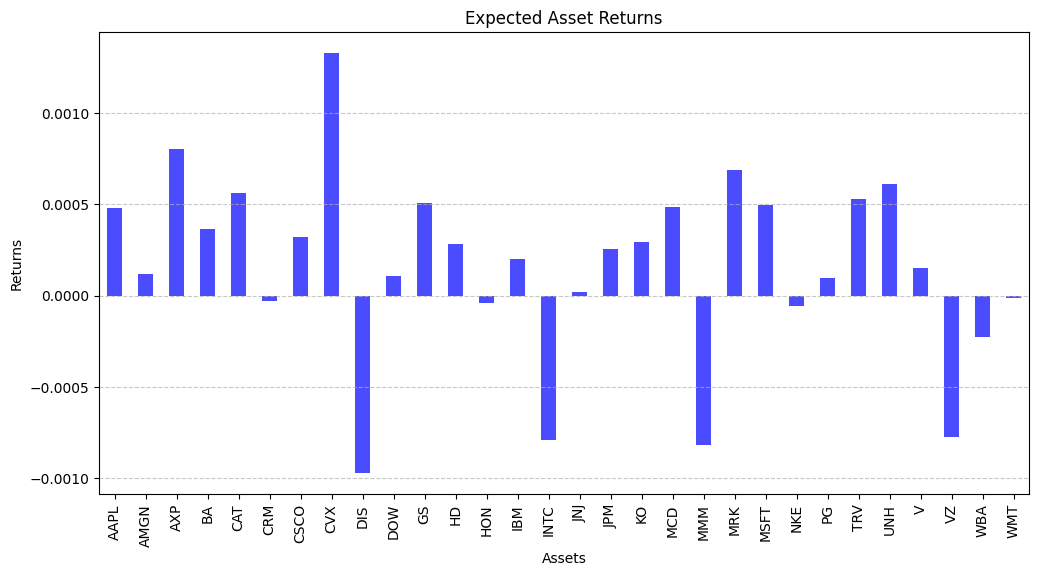

In [17]:
Sigma = yf_train_df.cov().to_numpy()
returns = yf_train_df.pct_change()
mu = returns.mean()

returns_test = yf_test_df.pct_change()
mu_test = returns.mean()
dist = (yf_test_df.iloc[-1] / yf_test_df.iloc[0]) - 1
Sigma_test = yf_test_df.cov()

plt.figure(figsize=(12, 6))
mu.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Expected Asset Returns')
plt.xlabel('Assets')
plt.ylabel('Returns')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# scipy optimization

\begin{align*}
\text{minimize} \quad & f(w) = w^T \Sigma w \\
\text{subject to} \quad &
\begin{aligned}
&\sum_{i=1}^{n} w_i = 1 \quad \text{(Budget Constraint)} \\
&w_i \geq 0, \quad i = 1, \ldots, n \quad \text{(Non-negativity Constraint)} \\
\end{aligned}
\end{align*}

In [9]:
from scipy.optimize import minimize

def risk_parity(Sigma, mu):
    n = len(mu)  # Number of assets

    def objective(w):
          var = Sigma.diagonal()
          s = w * var
          m = np.sum(s)
          k = ((w * s) / m) - 1/n
          return np.sum(np.power(k, 2))

    # Constraints
    constraints = [
        {"type": "eq", "fun": lambda w: w.sum() - 1}  # Budget constraint
    ]

    bounds = [(0, 1) for _ in range(n)]  # Non-negativity constraint

    w0 = [1/n] * n  # Initial guess for weights

    result = minimize(objective, w0, bounds=bounds, constraints=constraints, method='SLSQP')

    return result

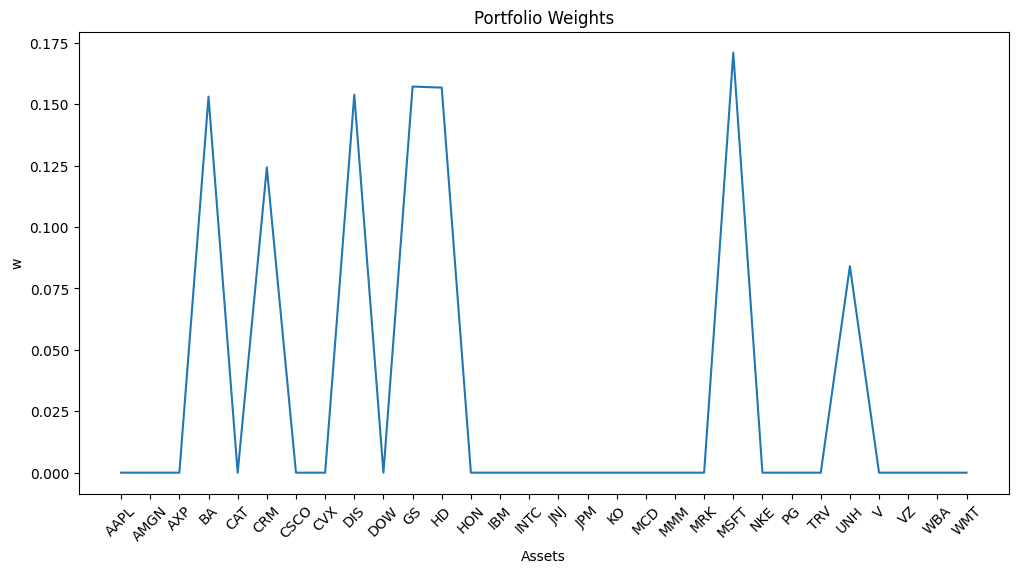

In [10]:
optim_result = risk_parity(Sigma, mu)
w = optim_result.x
plot_weights(w)

In [18]:
# w = np.array(list(weights.values()))
performance(w, mu_test, dist, Sigma_test)

Expected annual return: 0.0%
annual return for 138 day: 4.1%
Annual volatility: 889.7%
Sharpe Ratio: 0.00


(0.00016309886359209484, 8.89670904110638, 1.8332493828730644e-05)

# cvxpy optimization

In [27]:
import cvxpy as cp

def risk_parity(Sigma, mu):
    n = len(mu)  # Number of assets

    w = cp.Variable(n)

    var = Sigma.diagonal()
    s = w @ var
    m = cp.sum(s)
    k = ((w * s) / m) - 1/n
    objective = cp.sum_squares(k)

    # Constraints
    constraints = [
        lambda w: cp.sum(w) == 1,  # Budget constraint
        lambda w: w >= 0,
        lambda w: w <= 1
    ]

    opt = cp.Problem(cp.Minimize(objective), [f(w) for f in constraints])
    opt.solve(verbose=True)

    return opt, w

In [28]:
optim_result, w = risk_parity(Sigma, mu)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Nov 10 12:39:27 PM: Your problem has 30 variables, 3 constraints, and 0 parameters.
(CVXPY) Nov 10 12:39:27 PM: It is compliant with the following grammars: 
(CVXPY) Nov 10 12:39:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 10 12:39:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


DCPError: ignored

# repo implementation

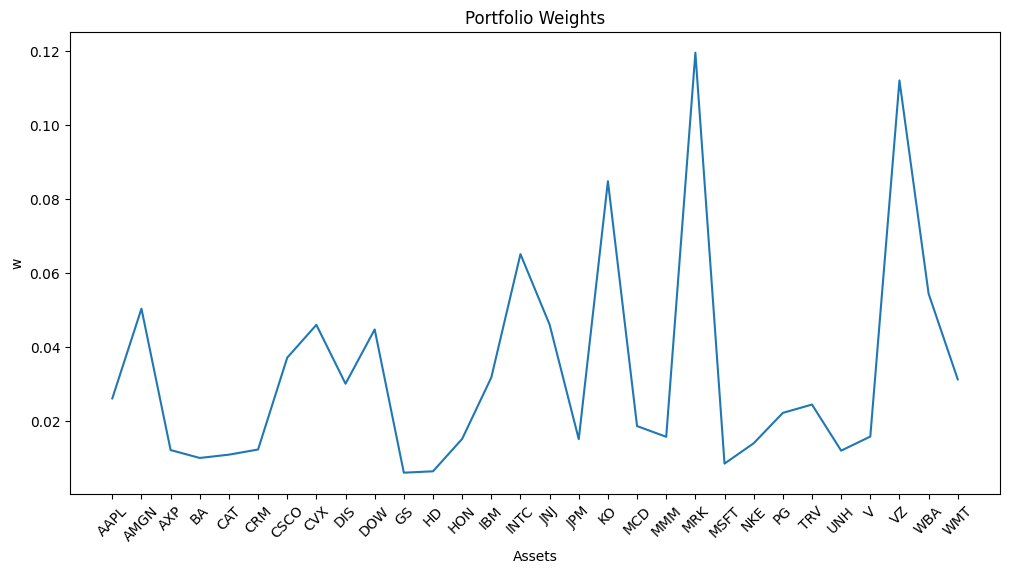

In [29]:
rp = RiskParity(cov=Sigma)
weights = rp.weight()
plot_weights(weights)

In [30]:
performance(weights, mu_test, dist, Sigma_test)

Expected annual return: 0.0%
annual return for 138 day: 0.2%
Annual volatility: 222.4%
Sharpe Ratio: 0.00


(8.232752747600646e-05, 2.224388038686451, 3.70113154917982e-05)